# In-sample analysis - example 
### Mixture of CVaR's with Sharpe type of optimization

This is an illustration of *in-sample analysis* workflow. 
The example presented here assumes a dispersion measure given by a mixture of CVaR's with Sharpe type of optimization (*i.e.* the portfolio that maximizes the mCVaR-Sharpe ratio).

> Note: A similar analysis can be performed for any other implemented risk measure and type of optimization.

We start by importing the **azapy** and other useful packages. 

In [6]:
import numpy as np
import pandas as pd

import sys
sys.path.append("..")
import azapy as az

### Collect the historical market data for a set of portfolio components.

- `symb` is the list of stock symbols (portfolio components).
- `sdate` and `edate` are the start and end dates of historical time-series.
- `mkdir` is the name of the directory used as a buffer for market data collected from the data provider *alphavantage*.
    
> Note: if the flag `force=False` then a reading from `dir=mktdir` is attempted. If it fails then the data provider servers will be accessed. The new data will be saved to the `mktdir`. *For more information see the `readMkT` documentation*

In [7]:
symb = ['GLD', 'TLT', 'XLV', 'VGT', 'PSJ']

sdate = pd.to_datetime("2012-01-01")
edate = pd.to_datetime("today")

mktdir = "./MkTdata"

mktdata = az.readMkT(symb, dstart = sdate, dend = edate, dir=mktdir, force=False) 

Read GLD form ./MkTdata
Read TLT form ./MkTdata
Read XLV form ./MkTdata
Read VGT form ./MkTdata
Read PSJ form ./MkTdata


### Set the mixture of CVaR's parameters

- `alpha` is the list of CVaR confidence levels 
- `coef` is the list of mixture coefficients. 
Note: `len(coef)=len(alpha)`. All the coefficients must be `>0`.

In [8]:
alpha = [0.95, 0.90, 0.85]
coef = [0.2, 0.3, 0.5]

### Set the CVaRAnalyzer class.

For a full list of available setting parameters see the documentation.

In [9]:
cr1 = az.CVaRAnalyzer(alpha, coef, mktdata)

### Compute the optimal weights

> Note: `rtype='Sharpe'` is the default setting. Therefore, it dose not need to be made explicitly. Other valid values for 
`rtype` are `'Risk'`, `'Sharpe2'`, `'InvNrisk'`, `'MinRisk'` are `'RiskAverse'`. *See the documentation of how to setup these optimization strategies.*

In [10]:
ww1 = cr1.getWeights(mu=0.)
print(f"optimal weights:\n {np.round(ww1,4)}")

optimal weights:
 symbol
GLD    0.5042
PSJ    0.0545
TLT    0.0678
VGT    0.1821
XLV    0.1914
dtype: float64


### Check the computation status

> Note: Normal exit is `0`. Any other value will signal a type of numerical error and a warning message will be printed.

In [11]:
status = cr1.status
print(f"Status: {status}")

Status: 0


### The risk of the optimal portfolio

In this case it is the value of the mixtures of CVaR's.

In [12]:
risk = cr1.risk
print(f"Risk: {risk}")

Risk: 0.07308650588511781


### Primary risk values

In this case the *primary risk* is the list of single CVaR's that enter in the mixture.

> Note: As a check: if `coef` is normalized to `1`, then `risk = np.dot(coef, primary_risk)`

The meaning of the *primary risk* varies with the risk measure adopted. *For more information see the documentation*.


In [13]:
primary_risk = cr1.primary_risk_comp
print(f"Primary Risk Components: {primary_risk}")

Primary Risk Components: [0.08468756 0.07470409 0.06747553]


### Secondary risk values

In this case the *secondary risk* is the list of VaR values associated with the CVaR's from *primary risk*.

The meaning of the *secondary risk* varies with the risk measure adopted. *For more information see the documentation.*

In [14]:
secondary_risk = cr1.secondary_risk_comp
print(f"Secondary Risk Components: {secondary_risk}")

Secondary Risk Components: [0.07212908 0.05787229 0.04926858]


### Portfolio expected rate of returns

> Note: It is a simple rate,in algebraic form, with horizon the rolling period of the portfolio. In this case a quarter.

In [15]:
RR = cr1.RR
print(f"Rate of Returns: {RR}")

Rate of Returns: 0.042532328997936054


### Sharpe ratio value

In [16]:
sharpe = cr1.sharpe
print(f"Sharpe ratio: {np.round(sharpe, 4)}")

Sharpe ratio: 0.5819


### View the portfolio frontiers 

- *blue* curve is the efficient frontier 
- *red* curve is the inefficient frontier
- Most left *green diamond* - is the *minimum risk portfolio*
- tangency point *(green diamond)* is the maximum Sharpe portfolio (also called *market* or *tangency* portfolio)
- *blue squares* with stock symbol labels are the single asset portfolio (the label designates the asset).
- *green x* with label "1/N" is the equal weights portfolio (also called *1/N* or *inverse-N* portfolio)
- *blue dots* are random (inefficient) portfolios. They are present here to visualize the area of admissible portfolios.

> Note: See the documentation for more details about available options.

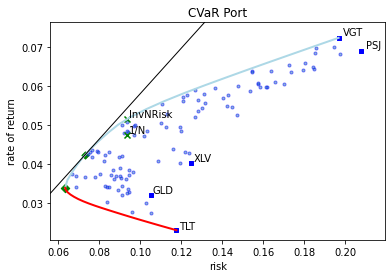

In [17]:
opt ={'title': "CVaR Port", 'tangent': True}

rft = cr1.viewFrontiers(musharpe=0, randomport=100, options=opt)

### View portfolio frontiers in a Sharle vs. rate of returns representations

> Note: In order to avoid recomputations that may take time we had reused the graphical information from the previous call to
`viewFrontiers`.

The meaning of the graphical features are the same as in the previous fig.

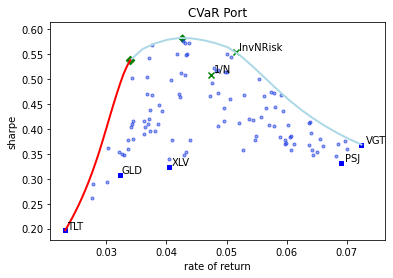

In [18]:
_ = cr1.viewFrontiers(data=rft, fig_type='Sharpe_RR')